In [26]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [27]:
# set number of assets (= number of qubits)
num_assets = 8
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

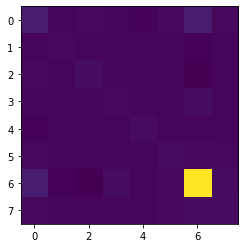

In [28]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [29]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.015284386652 x_0 + 0.000780952145 x_1 - 0.000517920547 x_2
      - 0.000870005837 x_3 - 0.010323519990 x_4 + 0.001666841256 x_5
      - 0.027213819622 x_6 - 0.000348237886 x_7 + [ 0.002541388592 x_0^2
      + 0.000146804433 x_0*x_1 + 0.000257201062 x_0*x_2 - 0.000199722426 x_0*x_3
      - 0.000626398406 x_0*x_4 + 0.000478782112 x_0*x_5 + 0.005160155269 x_0*x_6
      + 0.000564541457 x_0*x_7 + 0.000258486713 x_1^2 + 0.000106085519 x_1*x_2
      + 0.000088963242 x_1*x_3 - 0.000026490315 x_1*x_4 - 0.000159895987 x_1*x_5
      - 0.000517341706 x_1*x_6 - 0.000034553283 x_1*x_7 + 0.000791504681 x_2^2
      - 0.000247774763 x_2*x_3 - 0.000001940547 x_2*x_4 - 0.000392649749 x_2*x_5
      - 0.001507503903 x_2*x_6 + 0.000157733994 x_2*x_7 + 0.000197892585 x_3^2
      + 0.000170306704 x_3*x_4 - 0.000047408731 x_3*x_5 + 0.001511766097 x_3*x_6
      - 0.000053521388 x_3*x_7 + 0.

In [30]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [31]:
%%time
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 1. 0. 1. 1. 0. 0. 0.], value -0.0241

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 1 1 0 0 0]	-0.0241		0.3216
[1 0 0 0 1 1 0 1]	-0.0216		0.2635
[1 1 1 1 0 0 0 0]	-0.0139		0.1171
[0 0 1 0 0 1 1 1]	-0.0036		0.1028
[1 0 1 0 0 1 0 1]	-0.0115		0.0958
[0 1 1 1 0 0 1 0]	-0.0058		0.0447
[0 0 0 0 1 1 1 1]	-0.0124		0.0377
[0 1 0 1 1 0 1 0]	-0.0148		0.0164
[0 0 1 0 1 1 1 1]	1.0756		0.0001
[0 0 0 0 0 1 1 1]	1.0864		0.0001
[1 1 0 1 0 0 0 0]	1.0751		0.0000
[0 1 0 1 0 0 1 0]	1.0841		0.0000
[0 1 1 1 1 0 1 0]	1.0732		0.0000
[1 0 0 0 0 1 0 1]	1.0775		0.0000
[1 1 1 1 1 0 0 0]	1.0647		0.0000
[0 0 1 0 0 1 0 1]	1.0908		0.0000
[0 1 0 1 1 0 0 0]	1.0792		0.0000
[1 1 0 1 1 0 0 1]	1.0651		0.0000
[1 0 1 0 1 1 0 1]	1.0672		0.0000
[1 1 1 1 0 0 1 0]	1.0718		0.0000
[1 0 0 0 1 0 0 1]	1.0649		0.0000
[1 1 0 1 1 1 0 0]	1.0669		0.0000
[1 1 0 1 0 0 1 0]	-0.0163		0.0000
[0 0 1 0 0 1 1 0]	1.0847		0.0000
[1 0 

[0 0 0 1 0 0 0 1]	4.3550		0.0000
[0 0 0 0 0 0 0 0]	17.4233		0.0000
[0 0 1 1 1 1 0 0]	-0.0092		0.0000
[1 0 0 1 1 1 0 0]	-0.0229		0.0000
[0 0 1 1 1 0 0 1]	-0.0109		0.0000
[1 0 1 0 1 0 0 0]	1.0646		0.0000
[0 1 0 0 0 0 0 1]	4.3567		0.0000
[0 0 0 1 0 1 0 0]	4.3570		0.0000
[0 1 1 1 1 1 1 1]	9.7878		0.0000
[1 1 1 1 1 1 1 1]	17.3993		0.0000
[0 1 1 0 1 0 0 1]	-0.0091		0.0000
[0 0 1 0 1 0 0 0]	4.3457		0.0000
[0 1 1 0 1 1 1 0]	1.0754		0.0000
[0 1 0 1 0 1 1 1]	1.0869		0.0000
[0 1 0 0 0 1 1 0]	1.0863		0.0000
CPU times: user 8.41 s, sys: 11 s, total: 19.4 s
Wall time: 6.99 s


In [32]:
%%time
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 0. 1. 0. 1. 0.], value -0.0280

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 1 0 1 0 0]	0.0016		0.0146
[0 1 0 1 0 1 0 1]	0.0021		0.0145
[0 0 1 1 0 1 0 1]	0.0009		0.0145
[0 1 1 0 0 1 0 1]	0.0027		0.0145
[0 1 1 0 0 1 1 0]	-0.0037		0.0145
[0 1 0 1 0 1 1 0]	-0.0027		0.0145
[0 1 0 0 0 1 1 1]	-0.0020		0.0144
[0 1 1 1 0 0 0 1]	0.0000		0.0144
[0 0 0 1 0 1 1 1]	-0.0027		0.0144
[0 0 1 0 0 1 1 1]	-0.0036		0.0144
[0 1 1 1 0 0 1 0]	-0.0058		0.0144
[0 0 1 1 0 0 1 1]	-0.0060		0.0144
[0 1 0 1 0 0 1 1]	-0.0044		0.0144
[0 1 1 0 0 0 1 1]	-0.0052		0.0144
[0 0 1 1 0 1 1 0]	-0.0045		0.0143
[0 1 1 0 1 1 0 0]	-0.0075		0.0143
[0 0 1 0 1 1 0 1]	-0.0081		0.0143
[0 0 0 1 1 1 0 1]	-0.0086		0.0143
[0 1 0 1 1 1 0 0]	-0.0079		0.0143
[0 1 0 0 1 1 0 1]	-0.0070		0.0143
[1 1 1 0 0 1 0 0]	-0.0111		0.0142
[1 1 0 1 0 1 0 0]	-0.0118		0.0142
[0 0 1 1 1 0 0 1]	-0.0109		0.0142
[0 1 0 0 1 1 1 0]	-0.0125		0.

[1 0 1 1 1 1 0 0]	1.0657		0.0000
[1 0 1 1 0 1 1 0]	1.0733		0.0000
CPU times: user 7.75 s, sys: 7.69 s, total: 15.4 s
Wall time: 6.62 s
